## Introduction

In this article we are going to look into how you can track various experiments using Tensorboard in PyTorch and use the tracking data to tune hyperparameters. First let us see what is experiment tracking and hyperparameter tuning. 

### Experiment Tracking

Experiment tracking refers to the process of collecting and organizing data related to machine learning experiments. It involves logging and monitoring various aspects of an experiment, such as the model architecture, hyperparameters, training progress, evaluation metrics, and visualizations.

Experiment tracking helps researchers and practitioners keep a record of their experiments, making it easier to reproduce and compare results. It enables better understanding of the experiment's behavior, aids in debugging, and facilitates collaboration within teams.

One popular tool for experiment tracking is TensorBoard, which is a web-based visualization tool provided by TensorFlow. While originally developed for TensorFlow, it can also be used with PyTorch, another popular deep learning framework.

TensorBoard provides a user-friendly interface to explore and analyze experiment data. It allows visualizing metrics like loss and accuracy over time, examining the model graph, visualizing histograms of weights and biases, and displaying images and embeddings. It also supports interactive visualizations such as 3D embeddings and custom plots.

By using TensorBoard, you can gain insights into your experiments, compare different models or hyperparameter settings, and make informed decisions for improving your machine learning models.

### Hyper Parameter Tuning
Hyperparameter tuning, also known as hyperparameter optimization, is the process of finding the optimal values for the hyperparameters of a machine learning model. Hyperparameters are configuration settings that are not learned from the data but are set prior to training and affect the learning process.

Examples of hyperparameters include learning rate, batch size, number of hidden layers, number of units in each layer, regularization parameters, and activation functions. The choice of hyperparameters can significantly impact the performance and generalization ability of a model.

Hyperparameter tuning is crucial because selecting appropriate values for hyperparameters can lead to better model performance. It involves systematically searching through a predefined space of possible hyperparameter values to find the combination that yields the best results.

There are several strategies for hyperparameter tuning, including:

1. Manual search: This involves manually selecting hyperparameter values based on prior knowledge, intuition, or trial and error. It is a simple approach but can be time-consuming and may not yield the best results.
2. Grid search: Grid search involves defining a grid of possible hyperparameter values and exhaustively searching through all combinations. It evaluates and compares models trained with each combination of hyperparameters. While it guarantees finding the best hyperparameter values within the defined grid, it can be computationally expensive when the search space is large.
3. Random search: Random search selects hyperparameter values randomly from a predefined distribution. It performs a specified number of random searches and evaluates the models trained with each set of hyperparameters. Random search is more efficient than grid search when the search space is large and it doesn't require exhaustive evaluation of all combinations.
4. Bayesian optimization: Bayesian optimization is an advanced technique that uses probabilistic models to predict the performance of different hyperparameter settings. It iteratively explores the search space by evaluating a few carefully selected points and updating the probabilistic model. Bayesian optimization can be more efficient than random search or grid search when the search space is large and expensive to evaluate.
5. Automated techniques: There are automated hyperparameter tuning techniques like genetic algorithms, evolutionary algorithms, and reinforcement learning-based approaches that aim to optimize hyperparameters automatically. These techniques use optimization algorithms to search the hyperparameter space based on fitness evaluation.

During hyperparameter tuning, it is common to use evaluation metrics such as accuracy, precision, recall, or mean squared error to assess the performance of the models trained with different hyperparameter values.

By tuning hyperparameters effectively, you can improve the performance and generalization of your machine learning models, leading to better results on unseen data. Experiment tracking tools like TensorBoard can be valuable in this process, as they allow you to monitor and compare the performance of different hyperparameter settings over time.

For this demonstration we will be using the simple but expensive grid search. In the later blogs I will show you how we can implement the other hyperparameter tuning algorithms. 

We will use the FashionMNIST dataset and tune the hyperparamters of our custom VGG model using Grid Search. 

Let's begin.

## Install and Import Dependencies

In [1]:
%pip install -q torchinfo torchmetrics tensorboard

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import os
from torchvision.transforms import Resize, Compose, ToTensor
import matplotlib.pyplot as plt
from torchinfo import summary
import torchmetrics
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

device = "cuda" if torch.cuda.is_available() else "cpu"

c:\Users\Lenovo\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Dataset and Dataloader

In [5]:
BATCH_SIZE = 32

if not os.path.exists("data"): os.mkdir("data")

train_transform = Compose([Resize((64,64)),
                           ToTensor()
                           ])
test_transform = Compose([Resize((64,64)),
                          ToTensor()
                          ])


training_dataset = torchvision.datasets.FashionMNIST(root = "data",
                                                     download = True,
                                                     train = True,
                                                     transform = train_transform)

test_dataset = torchvision.datasets.FashionMNIST(root = "data",
                                                 download = True,
                                                 train = False,
                                                 transform = test_transform)

train_dataloader = torch.utils.data.DataLoader(training_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = BATCH_SIZE,
                                              shuffle = False,
                                              )

Let us see how many examples are there in the training set and the test set

In [6]:
print(f"Number of Images in test dataset is {len(test_dataset)}")
print(f"Number of Images in training dataset is {len(training_dataset)}")

Number of Images in test dataset is 10000
Number of Images in training dataset is 60000


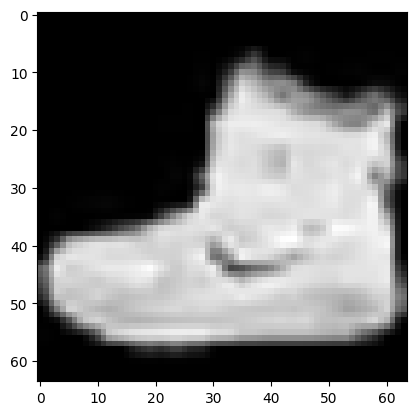

In [8]:
plt.imshow(training_dataset[0][0].permute((1,2,0)), cmap = "gray")

## Create a TinyVGG Model

In [10]:
class TinyVGG(torch.nn.Module):
  def __init__(self, in_channels, n_classes, hidden_units, n_conv_blocks, dropout):
    super().__init__()
    self.in_channels = in_channels
    self.out_features = n_classes
    self.dropout = dropout
    self.hidden_units = hidden_units

    self.input_block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = in_channels,
                        out_channels=hidden_units,
                        kernel_size = 3,
                        padding = 0,
                        stride = 1),
        torch.nn.Dropout(dropout),
        torch.nn.ReLU(),
    )

    self.conv_block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels = hidden_units,
                        out_channels = hidden_units,
                        kernel_size = 3,
                        padding = 0,
                        stride = 1),
        torch.nn.Dropout(dropout),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.classifier = torch.nn.Sequential(torch.nn.Flatten(),
                                          torch.nn.LazyLinear(
                                                          out_features = n_classes))

    self.vgg_block = torch.nn.Sequential(self.input_block,
                                         *[self.conv_block for _ in range(n_conv_blocks)],
                                         self.classifier)

  def forward(self, x):
    return self.vgg_block(x)

In [11]:
model =  TinyVGG(in_channels = 1,
                 n_classes = len(training_dataset.classes),
                 hidden_units = 16,
                 n_conv_blocks = 3,
                 dropout = 0.1).to(device)
summary(model, [1,64,64], batch_dim = 1)

c:\Users\Lenovo\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Sequential: 2-1                   [1, 16, 62, 62]           --
│    │    └─Conv2d: 3-1                  [1, 16, 62, 62]           160
│    │    └─Dropout: 3-2                 [1, 16, 62, 62]           --
│    │    └─ReLU: 3-3                    [1, 16, 62, 62]           --
│    └─Sequential: 2-2                   [1, 16, 30, 30]           --
│    │    └─Conv2d: 3-4                  [1, 16, 60, 60]           2,320
│    │    └─Dropout: 3-5                 [1, 16, 60, 60]           --
│    │    └─ReLU: 3-6                    [1, 16, 60, 60]           --
│    │    └─MaxPool2d: 3-7               [1, 16, 30, 30]           --
│    └─Sequential: 2-3                   [1, 16, 14, 14]           (recursive)
│    │    └─Conv2d: 3-8                  [1, 16, 28, 28]           (recu

In [ ]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

Here, there are several hyperparameters as you can see - Learning Rate, Number of Epochs, type of optimizer, number of convolution layers, dropout and number of hidden units. We can first fix the learning rate and number of epoch and try to find the best optimizer, convolution layers, dropout and hidden units. Once we have those we can then tune the number of epochs and learning rate. 

In [14]:
hparams_config = {
    "n_conv_layers" : [2, 4, 6],
    "dropout": [0.1, 0.2],
    "optimizer": ['adam', 'sgd'],
    "hidden_units": [8, 10, 12, 16]
}

EPOCHS = 4
LEARNING_RATE = 0.001

In [15]:
for n_conv_layers in hparams_config["n_conv_layers"]:
    for dropout in hparams_config["dropout"]:
        for optimizer in hparams_config["optimizer"]:
            for hidden_units in hparams_config["hidden_units"]:
                print(
                    f"Tuning HyperParameters || Number of Conv Layers: {n_conv_layers} || Dropout: {dropout} || Optimizer: {optimizer} || Hidden Units: {hidden_units}"
                )

Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: adam || Hidden Units: 8
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: adam || Hidden Units: 10
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: adam || Hidden Units: 12
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: adam || Hidden Units: 16
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: sgd || Hidden Units: 8
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: sgd || Hidden Units: 10
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: sgd || Hidden Units: 12
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.1 || Optimizer: sgd || Hidden Units: 16
Tuning HyperParameters || Number of Conv Layers: 2 || Dropout: 0.2 || Optimizer: adam || Hidden Units: 8
Tuning HyperParameters || Number of Conv Layers: 2 ||